<a href="https://colab.research.google.com/github/rh2098ta/Final-Capstone-Project/blob/main/Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('.')
FIG_DIR = Path('./figures')
FIG_DIR.mkdir(exist_ok=True)

In [ ]:
races = pd.read_csv(DATA_DIR/'races.csv')
results = pd.read_csv(DATA_DIR/'results.csv')
drivers = pd.read_csv(DATA_DIR/'drivers.csv')
constructors = pd.read_csv(DATA_DIR/'constructors.csv')

for name, df in {"races": races, "results": results, "drivers": drivers, "constructors": constructors}.items():
    print(name, df.shape)
    display(df.head(3))


races (1125, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


results (26759, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1


drivers (861, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg


constructors (212, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...


In [ ]:
Xy = (results
      .merge(races[['raceId','year','round','circuitId','name','date']], on='raceId', how='left')
      .merge(drivers[['driverId','driverRef','dob']], on='driverId', how='left')
      .merge(constructors[['constructorId','name']].rename(columns={'name':'constructor_name'}),
             on='constructorId', how='left'))

Xy['podium'] = (Xy['positionOrder'] <= 3).astype(int)

Xy = Xy.sort_values(['driverId','year','round','raceId']).reset_index(drop=True)

Xy['driver_starts_so_far'] = Xy.groupby('driverId').cumcount()

driver_prev_podium = Xy.groupby('driverId')['podium'].shift(1).fillna(0).astype(int)

Xy['driver_podiums_so_far'] = driver_prev_podium.groupby(Xy['driverId']).cumsum()

Xy['driver_podium_rate_so_far'] = np.where(
    Xy['driver_starts_so_far'] > 0,
    Xy['driver_podiums_so_far'] / Xy['driver_starts_so_far'],
    0.0
)

Xy['team_starts_so_far'] = Xy.groupby('constructorId').cumcount()

team_prev_podium = Xy.groupby('constructorId')['podium'].shift(1).fillna(0).astype(int)
Xy['team_podiums_so_far'] = team_prev_podium.groupby(Xy['constructorId']).cumsum()

Xy['team_podium_rate_so_far'] = np.where(
    Xy['team_starts_so_far'] > 0,
    Xy['team_podiums_so_far'] / Xy['team_starts_so_far'],
    0.0
)

features = [
    'grid', 'year',
    'driver_starts_so_far', 'driver_podium_rate_so_far',
    'team_starts_so_far',   'team_podium_rate_so_far'
]

model_df = Xy.dropna(subset=['positionOrder'])[features + ['podium','raceId','driverId','constructorId']].copy()
model_df.head()


,grid,year,driver_starts_so_far,driver_podium_rate_so_far,team_starts_so_far,team_podium_rate_so_far,podium,raceId,driverId,constructorId
0,4,2007,0,0.0,0,0.0,1,36,1,1
1,4,2007,1,1.0,1,1.0,1,37,1,1
2,2,2007,2,1.0,2,1.0,1,38,1,1
3,4,2007,3,1.0,3,1.0,1,39,1,1
4,2,2007,4,1.0,4,1.0,1,40,1,1


,missing_rate
grid,0.0
year,0.0
driver_starts_so_far,0.0
driver_podium_rate_so_far,0.0
team_starts_so_far,0.0
team_podium_rate_so_far,0.0
podium,0.0
raceId,0.0
driverId,0.0
constructorId,0.0


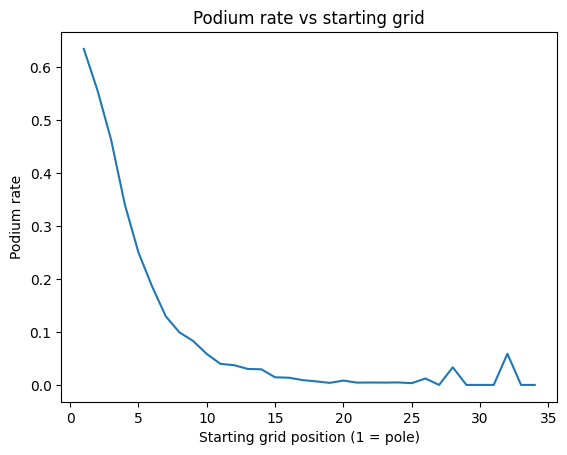

In [ ]:
miss = model_df.isna().mean().sort_values(ascending=False)
display(miss.to_frame('missing_rate').head(20))

tmp = Xy[Xy['grid']>=1].copy()
tmp['is_podium'] = (tmp['positionOrder']<=3).astype(int)
grid_podium = tmp.groupby('grid')['is_podium'].mean().reset_index()

plt.figure()
plt.plot(grid_podium['grid'], grid_podium['is_podium'])
plt.xlabel('Starting grid position (1 = pole)')
plt.ylabel('Podium rate')
plt.title('Podium rate vs starting grid')
plt.savefig(FIG_DIR/'podium_rate_vs_grid.png', bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

year_cut = int(np.quantile(model_df['year'], 0.8))
train = model_df[model_df['year'] <= year_cut]
test  = model_df[model_df['year'] >  year_cut]

X_train = train[features]
y_train = train['podium'].astype(int)
X_test  = test[features]
y_test  = test['podium'].astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print('ROC-AUC:', round(roc_auc_score(y_test, proba), 3))
print('Accuracy:', round(accuracy_score(y_test, pred), 3))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))


ROC-AUC: 0.918
Accuracy: 0.892
Confusion matrix:
 [[4099  204]
 [ 339  402]]


In [ ]:
test_with_pred = test.assign(pred_proba=proba)

def top3_hit_rate(df):
    top3 = df.sort_values('pred_proba', ascending=False).head(3)
    return top3['podium'].sum()/3.0

race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)
print('Avg fraction of correct picks among top-3 predictions:', round(race_hits.mean(), 3))


Avg fraction of correct picks among top-3 predictions: 0.615


/tmp/ipython-input-4238371351.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)


/tmp/ipython-input-129074652.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pod_by_team = tmp.groupby('team_rate_bin')['podium'].mean().reset_index()


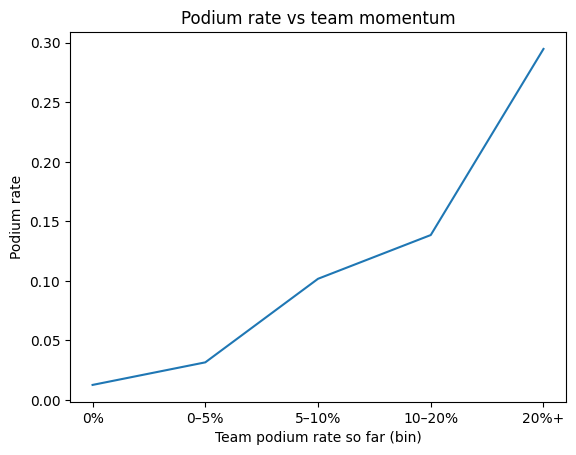

In [ ]:

bins = [-0.01, 0.00, 0.05, 0.10, 0.20, 1.00]
labels = ['0%','0–5%','5–10%','10–20%','20%+']
tmp = model_df.copy()
tmp['team_rate_bin'] = pd.cut(tmp['team_podium_rate_so_far'], bins=bins, labels=labels)
pod_by_team = tmp.groupby('team_rate_bin')['podium'].mean().reset_index()
plt.figure(); plt.plot(pod_by_team['team_rate_bin'], pod_by_team['podium'])
plt.title('Podium rate vs team momentum'); plt.xlabel('Team podium rate so far (bin)'); plt.ylabel('Podium rate')
plt.savefig('figures/podium_vs_team_momentum.png', bbox_inches='tight'); plt.show()


/tmp/ipython-input-718016445.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hits_per_race = test_logit.groupby('raceId').apply(_count_correct_top3)


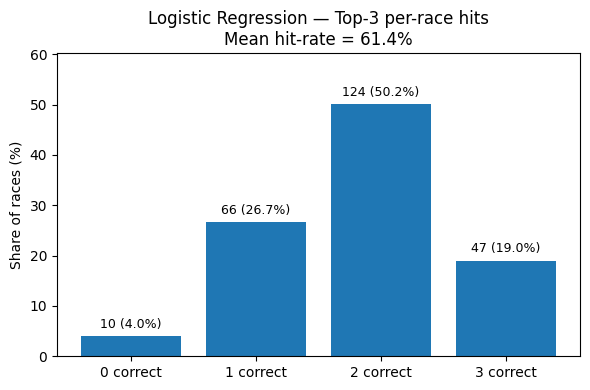

Saved figure: figures/top3_hits_logit.png


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


FIG_DIR = Path('figures'); FIG_DIR.mkdir(exist_ok=True)

test_logit = test.copy()
test_logit['pred_proba'] = proba_logit

def _count_correct_top3(df):
    top3 = df.sort_values('pred_proba', ascending=False).head(3)
    return int(top3['podium'].sum())

hits_per_race = test_logit.groupby('raceId').apply(_count_correct_top3)


buckets = [0, 1, 2, 3]
counts = [int((hits_per_race == k).sum()) for k in buckets]
total = len(hits_per_race)
perc = [c / total * 100 for c in counts]


mean_hit_rate_pct = (hits_per_race / 3).mean() * 100


plt.figure(figsize=(6,4))
x = np.arange(len(buckets))
plt.bar(x, perc)
plt.xticks(x, [f"{k} correct" for k in buckets])
plt.ylabel("Share of races (%)")
plt.title("Logistic Regression — Top-3 per-race hits\n"
          f"Mean hit-rate = {mean_hit_rate_pct:.1f}%")

#
for i, p in enumerate(perc):
    plt.text(i, p + 1, f"{counts[i]} ({p:.1f}%)", ha="center", va="bottom", fontsize=9)


plt.ylim(0, max(perc) * 1.2 if total > 0 else 1)
plt.tight_layout()
plt.savefig(FIG_DIR / "top3_hits_logit.png", bbox_inches="tight")
plt.show()

print("Saved figure:", FIG_DIR / "top3_hits_logit.png")


/tmp/ipython-input-4111079371.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hits_per_race_tree = test_tree_vis.groupby('raceId').apply(_count_correct_top3)


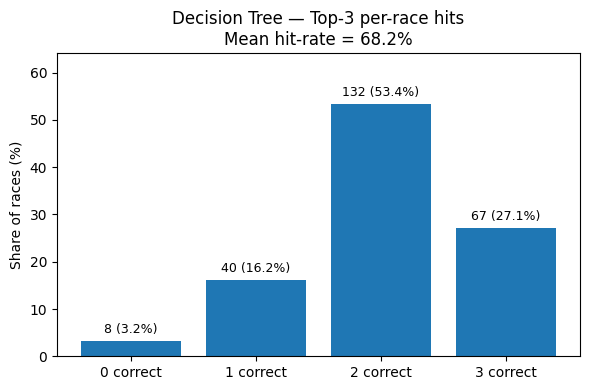

Saved figure: figures/top3_hits_tree.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path('figures'); FIG_DIR.mkdir(exist_ok=True)

test_tree_vis = test.copy()
test_tree_vis['pred_proba'] = proba_tree

def _count_correct_top3(df):
    top3 = df.sort_values('pred_proba', ascending=False).head(3)
    return int(top3['podium'].sum())

hits_per_race_tree = test_tree_vis.groupby('raceId').apply(_count_correct_top3)


buckets = [0, 1, 2, 3]
counts = [int((hits_per_race_tree == k).sum()) for k in buckets]
total = len(hits_per_race_tree)
perc = [c / total * 100 if total > 0 else 0.0 for c in counts]


mean_hit_rate_pct = (hits_per_race_tree / 3).mean() * 100 if total > 0 else 0.0


plt.figure(figsize=(6,4))
x = np.arange(len(buckets))
plt.bar(x, perc)
plt.xticks(x, [f"{k} correct" for k in buckets])
plt.ylabel("Share of races (%)")
plt.title("Decision Tree — Top-3 per-race hits\n"
          f"Mean hit-rate = {mean_hit_rate_pct:.1f}%")


for i, p in enumerate(perc):
    plt.text(i, p + 1, f"{counts[i]} ({p:.1f}%)", ha="center", va="bottom", fontsize=9)

plt.ylim(0, max(perc) * 1.2 if total > 0 else 1)
plt.tight_layout()
plt.savefig(FIG_DIR / "top3_hits_tree.png", bbox_inches="tight")
plt.show()

print("Saved figure:", FIG_DIR / "top3_hits_tree.png")


In [ ]:
from pathlib import Path
FIG_DIR = Path('figures'); FIG_DIR.mkdir(exist_ok=True)


In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

X = model_df[features].copy()
y = model_df['podium'].astype(int).copy()
groups_all = model_df['year']
cv = GroupKFold(n_splits=5)


logit = LogisticRegression(max_iter=1000)
param_logit = {'C': [0.5, 1.0, 2.0]}
gs_logit = GridSearchCV(logit, param_logit, cv=cv, scoring='roc_auc', n_jobs=-1)
gs_logit.fit(X, y, groups=groups_all)
best_logit = gs_logit.best_estimator_
print("Best Logistic:", gs_logit.best_params_, "CV AUC:", round(gs_logit.best_score_, 3))


tree = DecisionTreeClassifier(random_state=0)
param_tree = {'max_depth': [3, 5, 7, None], 'min_samples_leaf': [1, 5]}
gs_tree = GridSearchCV(tree, param_tree, cv=cv, scoring='roc_auc', n_jobs=-1)
gs_tree.fit(X, y, groups=groups_all)
best_tree = gs_tree.best_estimator_
print("Best Tree:", gs_tree.best_params_, "CV AUC:", round(gs_tree.best_score_, 3))


Best Logistic: {'C': 2.0} CV AUC: 0.876
Best Tree: {'max_depth': 5, 'min_samples_leaf': 5} CV AUC: 0.896


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def eval_model(name, model, Xtrain, ytrain, Xtest, ytest):
    model.fit(Xtrain, ytrain)
    proba = model.predict_proba(Xtest)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    auc   = roc_auc_score(ytest, proba)
    acc   = accuracy_score(ytest, pred)
    cm    = confusion_matrix(ytest, pred)
    print(f"{name} — Test AUC: {auc:.3f} | Acc: {acc:.3f}")
    print("Confusion matrix:\n", cm)
    return proba, pred, auc, acc, cm

proba_logit, pred_logit, auc_logit, acc_logit, cm_logit = eval_model(
    "Logistic", best_logit, X_train, y_train, X_test, y_test
)
proba_tree, pred_tree, auc_tree, acc_tree, cm_tree = eval_model(
    "DecisionTree", best_tree, X_train, y_train, X_test, y_test
)


Logistic — Test AUC: 0.918 | Acc: 0.893
Confusion matrix:
 [[4098  205]
 [ 337  404]]
DecisionTree — Test AUC: 0.926 | Acc: 0.897
Confusion matrix:
 [[4184  119]
 [ 399  342]]


In [ ]:
def top3_hit_rate_per_race(df_with_proba):
    def _race_hit(d):
        top3 = d.sort_values('pred_proba', ascending=False).head(3)
        return top3['podium'].sum() / 3.0
    return df_with_proba.groupby('raceId').apply(_race_hit).mean()

test_logit = test.copy(); test_logit['pred_proba'] = proba_logit
test_tree  = test.copy(); test_tree['pred_proba']  = proba_tree

thr_logit = top3_hit_rate_per_race(test_logit)
thr_tree  = top3_hit_rate_per_race(test_tree)

print(f"Top-3 hit-rate — Logistic: {thr_logit:.3f} | Tree: {thr_tree:.3f}")


Top-3 hit-rate — Logistic: 0.614 | Tree: 0.682


/tmp/ipython-input-3784747294.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_with_proba.groupby('raceId').apply(_race_hit).mean()
/tmp/ipython-input-3784747294.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_with_proba.groupby('raceId').apply(_race_hit).mean()


<Figure size 640x480 with 0 Axes>

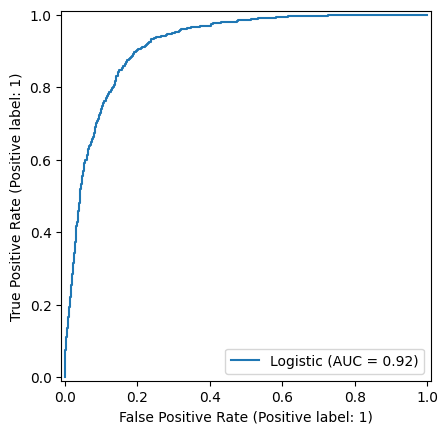

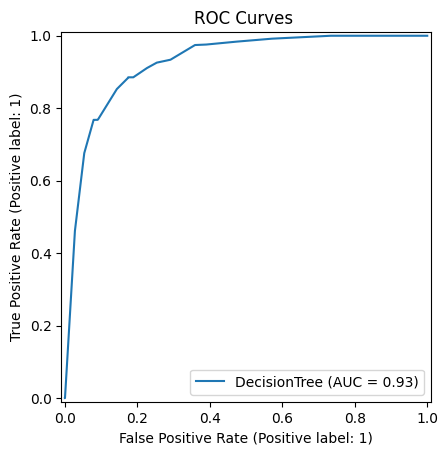

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_logit, name="Logistic")
RocCurveDisplay.from_predictions(y_test, proba_tree,  name="DecisionTree")
plt.title("ROC Curves ")
plt.savefig(FIG_DIR/'roc_models.png', bbox_inches='tight'); plt.show()


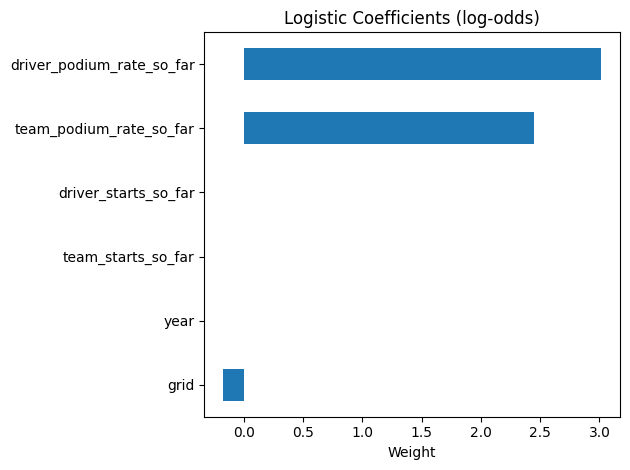

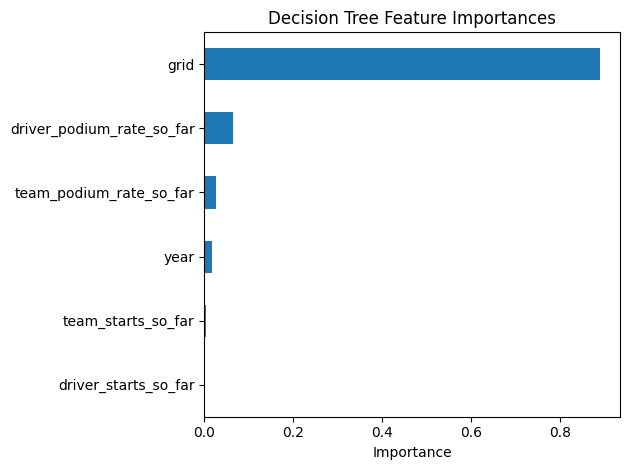

In [ ]:
# Logistic coefficients
coef_s = pd.Series(best_logit.coef_[0], index=features).sort_values()
plt.figure(); coef_s.plot(kind='barh')
plt.title("Logistic Coefficients (log-odds)"); plt.xlabel("Weight")
plt.tight_layout(); plt.savefig(FIG_DIR/'logit_coefficients.png', bbox_inches='tight'); plt.show()

# Tree importances
imp_s = pd.Series(best_tree.feature_importances_, index=features).sort_values()
plt.figure(); imp_s.plot(kind='barh')
plt.title("Decision Tree Feature Importances"); plt.xlabel("Importance")
plt.tight_layout(); plt.savefig(FIG_DIR/'tree_importances.png', bbox_inches='tight'); plt.show()


## Data Cleaning Decisions
- Sorted rows by driver → year → round → raceId so any “so-far” stats only use past races
.
- Engineered pre-race features only: `grid`, `year`, driver/team starts so far, driver/team podiums so far, and their rates.
- Kept grid = 0 rows for modeling (pit-lane/unknown starts); dropped only from the grid plot where needed.
- Checked key features for missing values — none were present after joins; string `position` not used (we used numeric `positionOrder`).
- Did not remove outliers; extreme values reflect real racing (e.g., very high/low grid positions). bold text


## Evaluation Choice (Plain English)
We report ROC-AUC because podiums are rare, and we care about how well the model ranks likely podium finishers above others across all cutoffs (0.50 = guessing, 1.00 = perfect). We include Accuracy for completeness, but it can be misleading with imbalance. We also report a Top-3 per-race hit-rate**: for each race, take the model’s top 3 predicted drivers and check what fraction actually podiumed—this mirrors the real decision teams make.


## Findings & Next Steps

### Findings (test set on newer seasons)
- Best model Decision Tree
- ROC-AUC: 0.926
- Accuracy .897  
- Top-3 per-race hit-rate 68.2%

What this means (nontechnical) Starting closer to the front and having stronger recent driver/team form both raise podium odds. The model’s ranking is useful: on average, about 68% of our “top-3” picks per race actually finish on the podium.

### Next steps
1. Add weather and circuit-type features (e.g., street vs permanent; recent rain).
2. Try gradient boosting and probability calibration to improve probability quality.
3. Package a race-day sheet: per-race top-3 list with confidence bands for sponsors/teams.
